In [1]:
# standard
import os
from datetime import datetime 

# third party
import covidcast
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy as sp
from sklearn.model_selection import LeaveOneOut

# first party
os.chdir("/Users/mjahja/Delphi/covidcast-nowcast/cases/deconv/code")
from weekday import Weekday

# Adjusting for day-of-week effects

As a preprocessing step (could be absorbed under the "sensorization" step, though it's different in spirit), we adjust each counties' case curve using a Poisson regression model. This is the same model used for adjusting the HSP signals, which was done by Aaron.

Let $C_{it}$ be the observed cases for location $i$ at time $t$. We assume

\begin{align}
\mathbb{E}[C_{it}] &= \mu_t\\
\log \mu_t &= \alpha_{wd(t)} + \phi_t
\end{align}

where $wd(t) \in \{0, ..., 6\}$ is the weekday corresponding to time $t$, and $\alpha_{wd(t)}$ is the correction for the weekday, and $\phi_t$ is the corrected case value. Notice we are fitting a single multiplier for each weekday, across all locations.

Since we will refit this model for each sequential timepoint, we assume that the weekday parameters do not change over time. We minimize the objective

\begin{align}
f(\alpha, \phi | \mu) &= - \log \ell(\alpha, \phi | \mu) + \lambda \lVert \Delta^3 \phi \rVert_1\\
\text{s.t.}\,\, \sum_{i=0}^6 \alpha_{wd(i)} &= 0 \Leftrightarrow \alpha_{wd(0)} = - \sum_{i=1}^6 \alpha_{wd(i)}
\end{align}
 
where $\ell$ represents the Poisson likelihood and $\Delta^3$ is the third-difference operator applied to $\phi$. The estimated counts are given by

\begin{equation}
\tilde C_{it} = C_{it} / \hat\alpha_{wd(t)}.
\end{equation}

## Fitting
Rewrite the problem as 
\begin{equation}
\log \mu_t = X\beta
\end{equation}
where the first 6 elements of $\beta \in \mathbb{R}^{6+T}$ correspond to $\alpha$, and the remaining $T$ elements (corresponding to all the training timepoints) correspond to $\phi$. The design matrix $X\in\mathbb{R}^{T\times (6+T)}$ has the form
\begin{equation}
X = 
\begin{bmatrix}
\vdots & & \vdots \\
\mathbf{1}_{i\ mod\ 7 = 1} & \cdots & \mathbf{1}_{i\ mod\ 7 = 6} & I_{T} \\
\vdots & &\vdots
\end{bmatrix}.
\end{equation}
In words, the rows of $X$ correspond to each timepoint, the first six columns are indicators for day-of-week, and the final $T$ columns are an identity matrix corresponding to unique $\phi_t$.

In [2]:
# get all florida fips codes
geo_map = pd.read_csv(
            "~/Delphi/covid-19/geographical_scope/02_20_uszips.csv",
            usecols=["fips", "state_id", "population"],
            dtype={"state_id": str},
            converters={"fips": lambda x: str(x).zfill(5)},
        )

geo_map = geo_map.groupby(['fips', 'state_id']).sum().reset_index()
florida_geo = geo_map[geo_map.state_id.eq("FL")]
florida_population = florida_geo.groupby("fips").population.sum().reset_index()
florida_fips = florida_geo.fips.unique()

In [3]:
# training dates
start_date = datetime(2020, 5, 15)
end_date = datetime(2020, 10, 15)

smoothed_cases_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='county')

raw_cases_df = covidcast.signal(
        'indicator-combination',
        'confirmed_incidence_num',
        start_date, end_date,
        geo_type='county')

/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20201012: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20201013: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20201014: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20201015: no results
  message=day_data["message"]))


In [4]:
raw_fl_cases = raw_cases_df[raw_cases_df.geo_value.isin(florida_fips)]
raw_fl_cases = raw_fl_cases.merge(florida_population, how="left", left_on="geo_value", right_on="fips")

raw_cases_df = raw_cases_df.groupby(['geo_value', 'time_value']).sum().reset_index()
raw_cases_df = raw_cases_df.merge(geo_map, how="left", left_on="geo_value", right_on="fips").dropna()

state_locs = raw_cases_df.state_id.unique()
state_cases_df = raw_cases_df.groupby(['state_id', 'time_value']).sum()

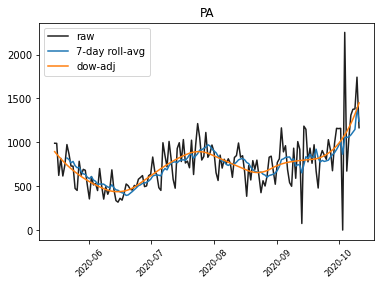

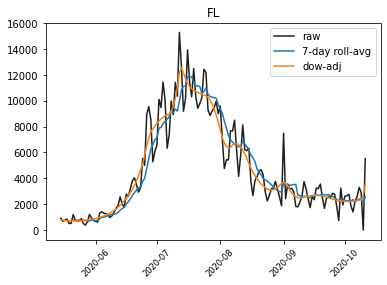

In [6]:
# weekday adjustment on US states
lam = 50
for loc in ["PA", "FL"]:
    loc_cases = state_cases_df.loc[loc].groupby("time_value").sum().value
    state_wd_params = Weekday.get_params(loc_cases, lam)
    adj_value = np.exp(state_wd_params[6:])
    
    dates = loc_cases.index
    plt.plot(dates, loc_cases.values, label="raw", color="black", alpha=0.88)
    plt.plot(dates, loc_cases.rolling(7).mean(), label="7-day roll-avg")
    plt.plot(dates, adj_value, label="dow-adj")
    plt.xticks(rotation=45, size="small")
    plt.title(loc)
    plt.legend()
    plt.show()

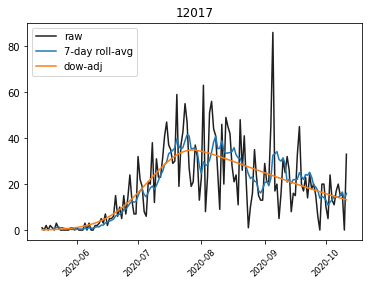

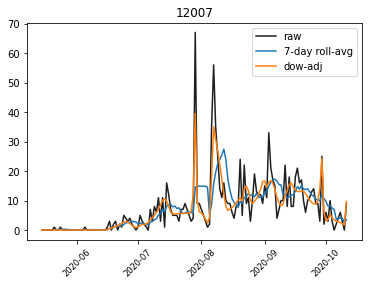

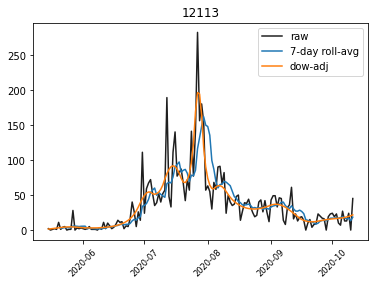

In [7]:
# weekday adjustment on florida counties

# sample a few counties
np.random.seed(2020)
locs = np.random.choice(raw_fl_cases.geo_value.unique(), 3)

# search over grid of lambdas
lam_grid = [1, 10, 25, 75, 100]

for loc in locs:
    loc_df = raw_fl_cases[raw_fl_cases.geo_value.eq(loc)]
    case_curve = loc_df.value.values.reshape(-1, 1)
    N = case_curve.size
    
    loo = LeaveOneOut()
    lam_scores = []
    for lam in lam_grid:
        score = []
        for train_i, test_i in loo.split(case_curve):
            test_i = test_i[0]
            if 1 < test_i < (N-2):
                raw_vals = loc_df.iloc[train_i].set_index("time_value")
                loo_params = Weekday.get_params(raw_vals.value, lam)
                fit = np.exp(loo_params[6:])
                preds_test = (fit[test_i-1] + fit[test_i+1])/2
                score.append(float(preds_test) - float(case_curve[test_i]))
            
        lam_scores.append(np.mean(np.square(score)))
        
    best_lam = lam_grid[np.argmin(lam_scores)]
    fips_wd_params = Weekday.get_params(loc_df.set_index("time_value").value, best_lam)
    adj_value = np.exp(fips_wd_params[6:])
    
    dates = loc_df.time_value
    plt.plot(dates, loc_df.value, label="raw", color="black", alpha=0.88)
    plt.plot(dates, loc_df.value.rolling(7).mean(), label="7-day roll-avg")
    plt.plot(dates, adj_value, label="dow-adj")
    plt.xticks(rotation=45, size="small")
    plt.title(loc)
    plt.legend()
    plt.show()